## Setup: Install Dependencies

Run this once to install required packages. Use the notebook kernel's Python (or your project venv). If you run the Streamlit app, make sure to run it from the project's venv to avoid Anaconda vs venv conflicts.

- Start Ollama in a separate terminal: `ollama serve`
- Pull the embedding model if needed: `ollama pull nomic-embed-text`
- To run the Streamlit app from the venv: `/path/to/project/venv/bin/streamlit run app.py`


In [1]:
# Install required packages (run in the notebook kernel's Python / venv)
import subprocess
import sys

packages = ['chromadb>=0.5.0', 'ollama', 'numpy', 'matplotlib', 'scikit-learn']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("✅ All packages installed (use the notebook kernel's Python).")
print("\nNotes:")
print("- If you run the Streamlit app, run it with your project's venv to avoid environment conflicts:")
print("    /path/to/your/project/venv/bin/streamlit run app.py")
print("- Make sure Ollama is running in a separate terminal:")
print("    ollama serve")
print("  and pull the model if needed:")
print("    ollama pull nomic-embed-text")

You should consider upgrading via the '/Users/ankit.jha/Documents/codes/llm_playground/RAG_101/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/ankit.jha/Documents/codes/llm_playground/RAG_101/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/ankit.jha/Documents/codes/llm_playground/RAG_101/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/ankit.jha/Documents/codes/llm_playground/RAG_101/venv/bin/python -m pip install --upgrade pip' command.


✅ All packages installed (use the notebook kernel's Python).

Notes:
- If you run the Streamlit app, run it with your project's venv to avoid environment conflicts:
    /path/to/your/project/venv/bin/streamlit run app.py
- Make sure Ollama is running in a separate terminal:
    ollama serve
  and pull the model if needed:
    ollama pull nomic-embed-text


You should consider upgrading via the '/Users/ankit.jha/Documents/codes/llm_playground/RAG_101/venv/bin/python -m pip install --upgrade pip' command.


## Part 1: Understanding Embeddings

### What are Embeddings?

Embeddings are vectors (lists of numbers) that represent the *semantic meaning* of text.

Instead of treating text as discrete symbols, embeddings capture relationships mathematically:
- Similar words → similar vectors
- Different words → different vectors
- Distance between vectors → semantic similarity

Let's see this in practice.

In [2]:
import requests
import numpy as np
from typing import List

class OllamaEmbedder:
    """Generate embeddings using local Ollama."""
    
    def __init__(self, model: str = "nomic-embed-text", base_url: str = "http://localhost:11434"):
        self.model = model
        self.base_url = base_url.rstrip("/")
        self.endpoint = f"{self.base_url}/api/embed"
        
        # Check connection
        try:
            response = requests.get(f"{self.base_url}/api/tags", timeout=2)
            print(f"✅ Connected to Ollama at {self.base_url}")
        except:
            print(f"❌ Cannot connect to Ollama at {self.base_url}")
            print(f"   Start Ollama: ollama serve")
            raise
    
    def embed(self, text: str) -> List[float]:
        """Generate embedding for a single text."""
        if not text.strip():
            return [0.0] * 768
        
        response = requests.post(
            self.endpoint,
            json={"model": self.model, "input": text.strip()},
            timeout=30
        )
        response.raise_for_status()
        
        data = response.json()
        return data["embeddings"][0]
    
    def embed_batch(self, texts: List[str]) -> List[List[float]]:
        """Generate embeddings for multiple texts."""
        return [self.embed(text) for text in texts]

# Initialize embedder
embedder = OllamaEmbedder()
print(f"Using model: nomic-embed-text (768 dimensions)")

/Users/ankit.jha/Documents/codes/llm_playground/RAG_101/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ Connected to Ollama at http://localhost:11434
Using model: nomic-embed-text (768 dimensions)


### Experiment 1: Embeddings Capture Meaning

Let's generate embeddings for similar and different texts and see the patterns.

In [3]:
# Generate embeddings for related texts
texts = [
    "Machine learning",
    "Artificial intelligence",
    "Deep learning",
    "Neural networks",
    "The weather is sunny",
    "I like to cook pizza",
]

print("Generating embeddings...")
embeddings = embedder.embed_batch(texts)
print(f"✅ Generated {len(embeddings)} embeddings")

# Show shape of an embedding
emb = embeddings[0]
print(f"\nEmbedding shape: {len(emb)} dimensions")
print(f"First 10 values: {emb[:10]}")
print(f"Vector magnitude: {np.linalg.norm(emb):.4f}")

Generating embeddings...
✅ Generated 6 embeddings

Embedding shape: 768 dimensions
First 10 values: [0.0030518973, -0.022623504, -0.11231421, -0.0197112, 0.03649401, -0.00988785, 0.0034683344, -0.007216019, -0.06811084, 0.0041231327]
Vector magnitude: 1.0000


## Part 2: Similarity Metrics

Now that we have embeddings, we need to measure how similar two texts are.

### Cosine Similarity

Cosine similarity measures the angle between two vectors:
- 1.0 = identical direction (same meaning)
- 0.5 = moderate similarity
- 0.0 = orthogonal (unrelated)

**Why cosine?** It's scale-invariant - doesn't matter if vectors are magnitude 1 or 10.

In [4]:
def cosine_similarity(vec1: List[float], vec2: List[float]) -> float:
    """Calculate cosine similarity between two vectors."""
    vec1 = np.array(vec1, dtype=np.float32)
    vec2 = np.array(vec2, dtype=np.float32)
    
    # Handle zero vectors
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0
    
    # cos(θ) = (A·B) / (||A|| * ||B||)
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    return float(dot_product / (norm1 * norm2))

def dot_product_similarity(vec1: List[float], vec2: List[float]) -> float:
    """Calculate dot product (raw alignment)."""
    return float(np.dot(np.array(vec1), np.array(vec2)))

def euclidean_similarity(vec1: List[float], vec2: List[float]) -> float:
    """Calculate Euclidean distance converted to similarity."""
    distance = np.linalg.norm(np.array(vec1) - np.array(vec2))
    return 1.0 / (1.0 + distance)  # Convert distance to similarity

print("Similarity metrics defined!")

Similarity metrics defined!


### Experiment 2: Compare Similarity Metrics

Let's see how different similarity metrics rank the same text pairs.

In [5]:
# Compare similarities
base_text = "Machine learning is a subset of AI"
base_embedding = embedder.embed(base_text)

test_texts = [
    "Machine learning algorithms learn from data",
    "Artificial intelligence enables intelligent systems",
    "The weather is sunny today",
    "Neural networks are inspired by brains",
]

test_embeddings = embedder.embed_batch(test_texts)

# Calculate similarities
print(f"Base text: '{base_text}'\n")
print(f"{'Text':<45} | {'Cosine':<8} | {'Dot':<8} | {'Euclidean':<8}")
print("-" * 80)

for text, emb in zip(test_texts, test_embeddings):
    cosine = cosine_similarity(base_embedding, emb)
    dot = dot_product_similarity(base_embedding, emb)
    euclidean = euclidean_similarity(base_embedding, emb)
    
    print(f"{text:<45} | {cosine:<8.4f} | {dot:<8.2f} | {euclidean:<8.4f}")

print("\n📊 Observations:")
print("- Cosine: Normalized (0 to 1), best for semantic similarity")
print("- Dot product: Raw values, depends on vector magnitude")
print("- Euclidean: Converted to similarity, captures distance")

Base text: 'Machine learning is a subset of AI'

Text                                          | Cosine   | Dot      | Euclidean
--------------------------------------------------------------------------------
Machine learning algorithms learn from data   | 0.7187   | 0.72     | 0.5714  
Artificial intelligence enables intelligent systems | 0.7057   | 0.71     | 0.5659  
The weather is sunny today                    | 0.4430   | 0.44     | 0.4865  
Neural networks are inspired by brains        | 0.6500   | 0.65     | 0.5445  

📊 Observations:
- Cosine: Normalized (0 to 1), best for semantic similarity
- Dot product: Raw values, depends on vector magnitude
- Euclidean: Converted to similarity, captures distance


## Part 3: Chunking Strategies

Documents are usually too large for optimal embedding. We need to break them into chunks.

### Why Chunking?
1. Embeddings lose information on very long texts
2. Search becomes too broad without chunking
3. Smaller chunks enable granular retrieval
4. Overlap improves recall by capturing context boundaries

In [6]:
from dataclasses import dataclass
from typing import List

@dataclass
class TextChunk:
    """Represents a chunk of text with metadata."""
    text: str
    chunk_id: str
    source_doc: str
    chunk_index: int = 0

class FixedSizeChunker:
    """Break text into fixed-size chunks with overlap."""
    
    def __init__(self, chunk_size: int = 500, overlap: int = 100):
        self.chunk_size = chunk_size
        self.overlap = overlap
    
    def chunk(self, text: str, source_doc: str = "document") -> List[TextChunk]:
        """Split text into chunks."""
        chunks = []
        step = self.chunk_size - self.overlap
        
        for i in range(0, len(text), step):
            chunk_text = text[i : i + self.chunk_size]
            
            if len(chunk_text.strip()) < 20:
                continue
            
            chunk = TextChunk(
                text=chunk_text,
                chunk_id=f"{source_doc}_chunk_{len(chunks)}",
                source_doc=source_doc,
                chunk_index=len(chunks)
            )
            chunks.append(chunk)
        
        return chunks

print("Chunking utilities defined!")

Chunking utilities defined!


### Experiment 3: Chunking Impact

See how different chunk sizes affect the number of chunks and overlap.

In [7]:
# Sample document
sample_doc = """
Machine learning is a subset of artificial intelligence that focuses on enabling systems 
to learn and improve from experience without being explicitly programmed. It is one of the most 
transformative technologies of our time, powering applications from recommendation systems to 
autonomous vehicles.

At its core, machine learning is about creating algorithms that can discover patterns in data 
and make predictions or decisions based on those patterns. Rather than following pre-programmed 
instructions, machine learning systems adjust their behavior based on the data they encounter.

Supervised learning involves training a model on labeled data. The training data includes both 
input features and the correct output (labels). The algorithm learns to map inputs to outputs 
and can then predict outputs for new, unseen inputs.

Unsupervised learning works with unlabeled data. The algorithm discovers hidden patterns or 
structure in the data without being told what to look for. Common unsupervised learning techniques 
include clustering, dimensionality reduction, and anomaly detection.
"""

# Test different chunk sizes
print(f"Document length: {len(sample_doc)} characters\n")
print(f"{'Chunk Size':<12} | {'Overlap':<8} | {'Chunks':<8} | {'Coverage %':<12}")
print("-" * 50)

for chunk_size in [200, 500, 1000]:
    for overlap in [0, 100]:
        chunker = FixedSizeChunker(chunk_size=chunk_size, overlap=overlap)
        chunks = chunker.chunk(sample_doc, "sample")

        # Calculate coverage (how much text is covered by chunks)
        if chunks:
            coverage = (len(chunks) * chunk_size) / len(sample_doc) * 100
        else:
            coverage = 0
        
        print(f"{chunk_size:<12} | {overlap:<8} | {len(chunks):<8} | {coverage:<12.1f}%")

print("\n📊 Observations:")
print("- Smaller chunks: More chunks, more granular, better for specific queries")
print("- Larger chunks: Fewer chunks, more context, less storage")
print("- Overlap: More chunks but better coverage at boundaries")

Document length: 1100 characters

Chunk Size   | Overlap  | Chunks   | Coverage %  
--------------------------------------------------
200          | 0        | 6        | 109.1       %
200          | 100      | 11       | 200.0       %
500          | 0        | 3        | 136.4       %
500          | 100      | 3        | 136.4       %
1000         | 0        | 2        | 181.8       %
1000         | 100      | 2        | 181.8       %

📊 Observations:
- Smaller chunks: More chunks, more granular, better for specific queries
- Larger chunks: Fewer chunks, more context, less storage
- Overlap: More chunks but better coverage at boundaries


## Part 4: Building a Vector Store

Now let's combine everything into a vector database using ChromaDB.

In [8]:
import chromadb
from pathlib import Path

class SimpleVectorStore:
    """Vector store using ChromaDB (new PersistentClient API)."""
    
    def __init__(self, persist_dir: str = "./chroma_notebook_db"):
        self.persist_dir = persist_dir
        Path(self.persist_dir).mkdir(parents=True, exist_ok=True)

        # Use the new PersistentClient for on-disk storage
        self.client = chromadb.PersistentClient(path=self.persist_dir)
        self.collection = self.client.get_or_create_collection(
            name="documents",
            metadata={"hnsw:space": "cosine"}
        )
    
    def add_chunks(self, chunks: List[TextChunk], embeddings: List[List[float]]):
        """Add chunks with embeddings to store."""
        ids = [chunk.chunk_id for chunk in chunks]
        texts = [chunk.text for chunk in chunks]
        metadatas = [
            {
                "source_doc": chunk.source_doc,
                "chunk_index": str(chunk.chunk_index),
            }
            for chunk in chunks
        ]
        
        self.collection.upsert(
            ids=ids,
            embeddings=embeddings,
            documents=texts,
            metadatas=metadatas
        )
        print(f"✅ Added {len(chunks)} chunks to vector store")
    
    def search(self, query_embedding: List[float], k: int = 5):
        """Search for similar chunks."""
        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=k,
            include=["documents", "metadatas", "distances"]
        )
        
        retrieved = []
        for i, chunk_id in enumerate(results["ids"][0]):
            text = results["documents"][0][i]
            metadata = results["metadatas"][0][i]
            distance = results["distances"][0][i]
            similarity = 1 - distance  # Convert distance to similarity
            
            retrieved.append({
                "text": text,
                "metadata": metadata,
                "similarity": similarity
            })
        
        return retrieved
    
    def get_info(self):
        """Get store information."""
        return {
            "total_chunks": self.collection.count(),
            "persist_dir": self.persist_dir
        }

# Initialize vector store
vector_store = SimpleVectorStore()
print("✅ Vector store initialized (PersistentClient)")

✅ Vector store initialized (PersistentClient)


## Part 5: Complete Semantic Search Pipeline

Let's put it all together!

In [9]:
class SemanticSearchPipeline:
    """Complete semantic search system."""
    
    def __init__(self, chunk_size: int = 500, overlap: int = 100):
        self.embedder = OllamaEmbedder()
        self.chunker = FixedSizeChunker(chunk_size=chunk_size, overlap=overlap)
        self.vector_store = SimpleVectorStore()
    
    def index_document(self, text: str, doc_name: str = "document"):
        """Index a document."""
        print(f"📄 Indexing '{doc_name}'...")
        
        # Chunk
        chunks = self.chunker.chunk(text, source_doc=doc_name)
        print(f"  ✂️  Created {len(chunks)} chunks")
        
        # Embed
        print(f"  🔄 Generating embeddings...")
        texts = [chunk.text for chunk in chunks]
        embeddings = self.embedder.embed_batch(texts)
        print(f"  ✅ Generated {len(embeddings)} embeddings")
        
        # Store
        self.vector_store.add_chunks(chunks, embeddings)
    
    def search(self, query: str, top_k: int = 3):
        """Search for similar content."""
        print(f"\n🔍 Searching for: '{query}'")
        
        # Embed query
        query_embedding = self.embedder.embed(query)
        
        # Search
        results = self.vector_store.search(query_embedding, k=top_k)
        
        print(f"\n📊 Results (top {len(results)}):")
        for i, result in enumerate(results, 1):
            print(f"\n[{i}] Score: {result['similarity']:.4f}")
            print(f"    Source: {result['metadata'].get('source_doc', 'unknown')}")
            text_preview = result['text'][:100].replace('\n', ' ')
            print(f"    Text: {text_preview}...")
        
        return results
    
    def get_stats(self):
        """Get statistics."""
        return self.vector_store.get_info()

# Initialize pipeline
pipeline = SemanticSearchPipeline(chunk_size=500, overlap=100)
print("✅ Semantic search pipeline ready!")

✅ Connected to Ollama at http://localhost:11434
✅ Semantic search pipeline ready!


### Experiment 4: Index and Search

Let's index sample documents and perform semantic searches.

In [10]:
# Sample documents
doc1 = """
Machine learning is a subset of artificial intelligence that focuses on enabling systems 
to learn and improve from experience without being explicitly programmed. It is one of the most 
transformative technologies of our time, powering applications from recommendation systems to 
autonomous vehicles.

At its core, machine learning is about creating algorithms that can discover patterns in data 
and make predictions or decisions based on those patterns. Rather than following pre-programmed 
instructions, machine learning systems adjust their behavior based on the data they encounter.

There are three main types of machine learning: supervised learning, unsupervised learning, and 
reinforcement learning. Supervised learning involves training on labeled data, unsupervised learning 
discovers patterns without labels, and reinforcement learning learns through trial and error.
"""

doc2 = """
Embeddings are vectors that represent the semantic meaning of text. Instead of treating words as 
discrete symbols, embeddings capture semantic relationships mathematically. Words with similar meanings 
have similar embeddings, enabling computers to reason about semantic similarity.

Embeddings are generated by neural networks trained on large amounts of text. Modern embedding models 
like BERT and nomic-embed-text can create high-quality 768-dimensional vectors that capture nuanced 
meaning. These embeddings enable semantic search, where queries are matched based on meaning rather 
than keywords.

Similarity between embeddings is typically measured using cosine similarity, which calculates the 
angle between vectors. A cosine similarity of 1.0 means identical direction (same meaning), 0.0 means 
orthogonal (unrelated), and negative values indicate opposite meanings.
"""

# Index documents
pipeline.index_document(doc1, "machine_learning_intro")
pipeline.index_document(doc2, "embeddings_guide")

# Print stats
stats = pipeline.get_stats()
print(f"\n📈 Index Statistics:")
print(f"  Total chunks: {stats['total_chunks']}")
print(f"  Storage: {stats['persist_dir']}")

📄 Indexing 'machine_learning_intro'...
  ✂️  Created 3 chunks
  🔄 Generating embeddings...
  ✅ Generated 3 embeddings
✅ Added 3 chunks to vector store
📄 Indexing 'embeddings_guide'...
  ✂️  Created 3 chunks
  🔄 Generating embeddings...
  ✅ Generated 3 embeddings
✅ Added 3 chunks to vector store

📈 Index Statistics:
  Total chunks: 6
  Storage: ./chroma_notebook_db


### Experiment 5: Try Different Queries

Test semantic search with various queries.

In [11]:
# Test queries
queries = [
    "What are embeddings?",
    "How does machine learning work?",
    "Explain neural networks",
    "What is semantic similarity?",
    "Different types of learning algorithms",
]

for query in queries:
    pipeline.search(query, top_k=2)


🔍 Searching for: 'What are embeddings?'

📊 Results (top 2):

[1] Score: 0.7900
    Source: embeddings_guide
    Text:  Embeddings are vectors that represent the semantic meaning of text. Instead of treating words as  d...

[2] Score: 0.6422
    Source: embeddings_guide
    Text: nd nomic-embed-text can create high-quality 768-dimensional vectors that capture nuanced  meaning. T...

🔍 Searching for: 'How does machine learning work?'

📊 Results (top 2):

[1] Score: 0.8023
    Source: machine_learning_intro
    Text:  Machine learning is a subset of artificial intelligence that focuses on enabling systems  to learn ...

[2] Score: 0.7553
    Source: machine_learning_intro
    Text: and make predictions or decisions based on those patterns. Rather than following pre-programmed  ins...

🔍 Searching for: 'Explain neural networks'

📊 Results (top 2):

[1] Score: 0.6100
    Source: machine_learning_intro
    Text:  Machine learning is a subset of artificial intelligence that focuses on enabli

## Part 6: Understanding Chunking Trade-offs

Let's systematically explore how different chunk sizes affect search results.

In [12]:
# Test different chunk sizes
print("🧪 Experiment: Chunk Size Impact\n")
print(f"{'Chunk Size':<12} | {'Chunks':<8} | {'Coverage %':<12}")
print("-" * 35)

for size in [250, 500, 1000]:
    p = SemanticSearchPipeline(chunk_size=size, overlap=100)
    p.index_document(doc1, "ml_intro")
    p.index_document(doc2, "embeddings")
    
    stats = p.get_stats()
    chunks = stats['total_chunks']
    total_chars = len(doc1) + len(doc2)
    coverage = (chunks * size) / total_chars * 100
    
    print(f"{size:<12} | {chunks:<8} | {coverage:<12.1f}%")
    
    # Test search with this configuration
    results = p.search("machine learning basics", top_k=1)
    top_score = results[0]['similarity'] if results else 0
    print(f"              Top search score: {top_score:.4f}")

print("\n💡 Key Insights:")
print("- Smaller chunks: More chunks, potentially more relevant results")
print("- Larger chunks: Fewer chunks, more context, less granular")
print("- Find the sweet spot based on your use case!")

🧪 Experiment: Chunk Size Impact

Chunk Size   | Chunks   | Coverage %  
-----------------------------------
✅ Connected to Ollama at http://localhost:11434
📄 Indexing 'ml_intro'...
  ✂️  Created 6 chunks
  🔄 Generating embeddings...
  ✅ Generated 6 embeddings
✅ Added 6 chunks to vector store
📄 Indexing 'embeddings'...
  ✂️  Created 6 chunks
  🔄 Generating embeddings...
  ✅ Generated 6 embeddings
✅ Added 6 chunks to vector store
250          | 18       | 254.7       %

🔍 Searching for: 'machine learning basics'

📊 Results (top 1):

[1] Score: 0.8191
    Source: ml_intro
    Text: es.  At its core, machine learning is about creating algorithms that can discover patterns in data  ...
              Top search score: 0.8191
✅ Connected to Ollama at http://localhost:11434
📄 Indexing 'ml_intro'...
  ✂️  Created 3 chunks
  🔄 Generating embeddings...
  ✅ Generated 3 embeddings
✅ Added 3 chunks to vector store
📄 Indexing 'embeddings'...
  ✂️  Created 3 chunks
  🔄 Generating embeddings...
  ✅ Gen

## Part 7: Visualizing Embeddings

Let's visualize embedding space using dimensionality reduction.

Generating embeddings for visualization...


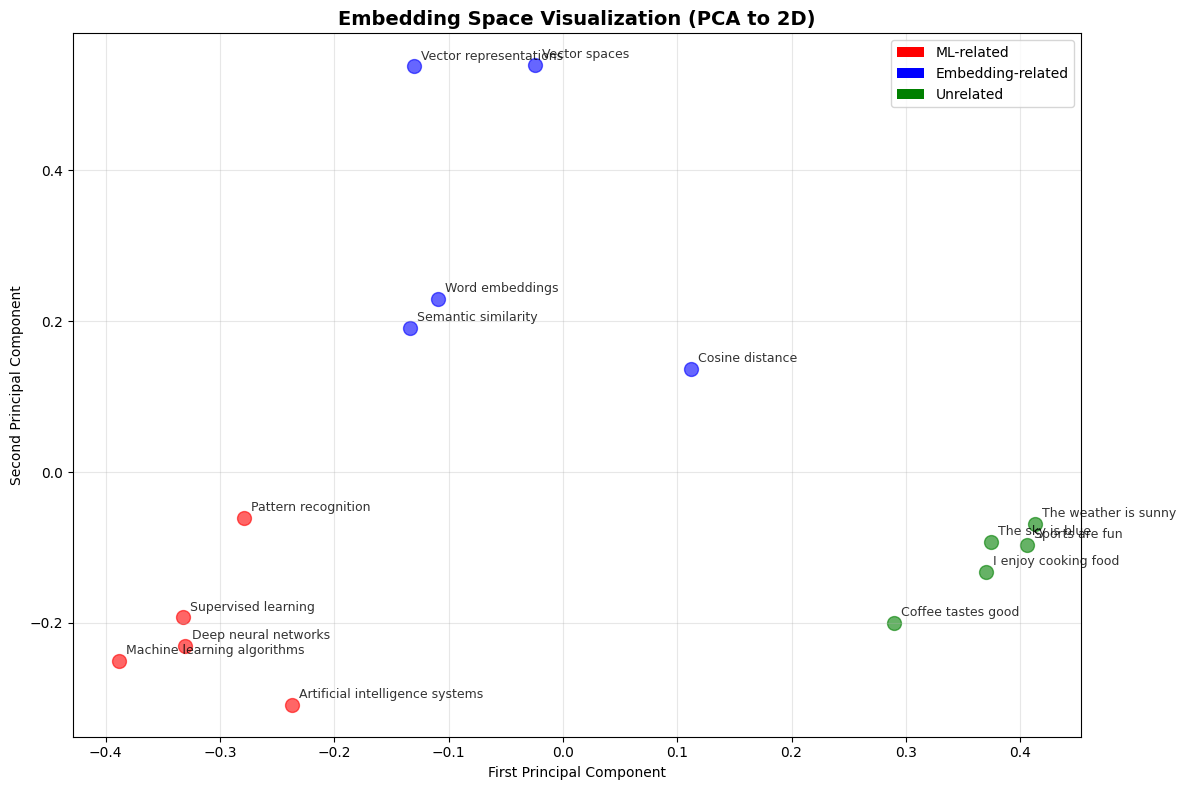

✅ Visualization complete!

Explained variance: 28.28%
Note: Similar concepts cluster together in embedding space!


In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate embeddings for various texts
texts = [
    # ML-related
    "Machine learning algorithms",
    "Deep neural networks",
    "Supervised learning",
    "Artificial intelligence systems",
    "Pattern recognition",
    
    # Embedding-related
    "Vector representations",
    "Semantic similarity",
    "Word embeddings",
    "Cosine distance",
    "Vector spaces",
    
    # Unrelated
    "The weather is sunny",
    "I enjoy cooking food",
    "The sky is blue",
    "Coffee tastes good",
    "Sports are fun",
]

# Generate embeddings
print("Generating embeddings for visualization...")
embeddings = embedder.embed_batch(texts)
embeddings_array = np.array(embeddings)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Plot
plt.figure(figsize=(12, 8))

# Color by category
colors = (
    ['red'] * 5 +      # ML-related
    ['blue'] * 5 +     # Embedding-related
    ['green'] * 5      # Unrelated
)

for i, (text, color) in enumerate(zip(texts, colors)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=color, s=100, alpha=0.6)
    plt.annotate(text, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                fontsize=9, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.title('Embedding Space Visualization (PCA to 2D)', fontsize=14, fontweight='bold')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='ML-related'),
    Patch(facecolor='blue', label='Embedding-related'),
    Patch(facecolor='green', label='Unrelated'),
]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")
print(f"\nExplained variance: {pca.explained_variance_ratio_.sum():.2%}")
print("Note: Similar concepts cluster together in embedding space!")

## Part 8: Similarity Score Analysis

Let's analyze how similarity scores correlate with semantic meaning.

In [14]:
# Generate embeddings
test_texts = [
    "Machine learning",
    "Artificial intelligence",
    "Deep learning",
    "Pattern recognition",
    "Neural networks",
    "Computer vision",
    "The weather today",
    "Cooking recipes",
]

base_text = "Machine learning"
base_emb = embedder.embed(base_text)
test_embs = embedder.embed_batch(test_texts)

# Calculate similarities
print(f"\n📊 Similarity Analysis")
print(f"Base text: '{base_text}'\n")
print(f"{'Text':<25} | {'Similarity':<12} | {'Category':<15}")
print("-" * 55)

for text, emb in zip(test_texts, test_embs):
    sim = cosine_similarity(base_emb, emb)
    
    if sim > 0.8:
        category = "Very Similar"
    elif sim > 0.7:
        category = "Similar"
    elif sim > 0.5:
        category = "Moderately Similar"
    else:
        category = "Different"
    
    print(f"{text:<25} | {sim:<12.4f} | {category:<15}")

print("\n💡 Interpretation:")
print("- 0.8+: Excellent semantic match")
print("- 0.7+: Very good match")
print("- 0.5+: Reasonable match")
print("- <0.5: Weak or no match")


📊 Similarity Analysis
Base text: 'Machine learning'

Text                      | Similarity   | Category       
-------------------------------------------------------
Machine learning          | 1.0000       | Very Similar   
Artificial intelligence   | 0.6196       | Moderately Similar
Deep learning             | 0.6988       | Moderately Similar
Pattern recognition       | 0.6203       | Moderately Similar
Neural networks           | 0.6694       | Moderately Similar
Computer vision           | 0.5453       | Moderately Similar
The weather today         | 0.3705       | Different      
Cooking recipes           | 0.3998       | Different      

💡 Interpretation:
- 0.8+: Excellent semantic match
- 0.7+: Very good match
- 0.5+: Reasonable match
- <0.5: Weak or no match


## Part 9: Limitations of Semantic Search

Semantic search is powerful but has limitations. Let's explore them.

In [15]:
print("⚠️  Limitations of Semantic Search\n")
print("1. NEGATION HANDLING")
print("-" * 50)

text = "Machine learning enables automatic pattern discovery"
vec = embedder.embed(text)

queries = [
    "Machine learning",
    "NOT machine learning",
    "Anything except machine learning",
]

for q in queries:
    qvec = embedder.embed(q)
    sim = cosine_similarity(vec, qvec)
    print(f"Query: '{q}'")
    print(f"  Similarity: {sim:.4f} (still high!)\n")

print("\n2. AMBIGUITY")
print("-" * 50)
query = "Python programming"
qvec = embedder.embed(query)

contexts = [
    "The Python programming language is great for ML",
    "Snakes like Python are found in jungles",
    "Monty Python is a comedy group",
]

for context in contexts:
    cvec = embedder.embed(context)
    sim = cosine_similarity(qvec, cvec)
    print(f"Context: '{context[:40]}...'")
    print(f"  Similarity: {sim:.4f}\n")

print("\n3. SEMANTIC DRIFT")
print("-" * 50)
queries = [
    "What is machine learning?",
    "How do machines learn?",
    "Can computers be intelligent?",
    "What does intelligence mean?",
]

base = "Machine learning algorithms"
base_vec = embedder.embed(base)

for q in queries:
    qvec = embedder.embed(q)
    sim = cosine_similarity(base_vec, qvec)
    print(f"Query: '{q}'")
    print(f"  Similarity: {sim:.4f}")
    if sim < 0.5:
        print(f"  Note: Semantic drift - too different\n")
    else:
        print()

⚠️  Limitations of Semantic Search

1. NEGATION HANDLING
--------------------------------------------------
Query: 'Machine learning'
  Similarity: 0.8120 (still high!)

Query: 'NOT machine learning'
  Similarity: 0.6577 (still high!)

Query: 'Anything except machine learning'
  Similarity: 0.6828 (still high!)


2. AMBIGUITY
--------------------------------------------------
Context: 'The Python programming language is great...'
  Similarity: 0.7430

Context: 'Snakes like Python are found in jungles...'
  Similarity: 0.5827

Context: 'Monty Python is a comedy group...'
  Similarity: 0.5624


3. SEMANTIC DRIFT
--------------------------------------------------
Query: 'What is machine learning?'
  Similarity: 0.8131

Query: 'How do machines learn?'
  Similarity: 0.6880

Query: 'Can computers be intelligent?'
  Similarity: 0.5138

Query: 'What does intelligence mean?'
  Similarity: 0.3906
  Note: Semantic drift - too different



## Part 10: Hands-On Experimentation

Now it's your turn! Experiment with different configurations and see how they affect results.

In [16]:
# ===== EXPERIMENT: Add Your Own Documents =====

my_documents = [
    {
        "name": "document_1",
        "text": """
        # Add your own text here
        You can paste any document content here.
        The system will automatically chunk and embed it.
        Then you can search across your documents!
        """
    },
    # Add more documents as needed
]

print("🧪 Your Personal Semantic Search Experiment")
print("="*50)
print()

# Create a fresh pipeline for your experiment
experiment_pipeline = SemanticSearchPipeline(chunk_size=500, overlap=100)

# Index your documents
for doc in my_documents:
    experiment_pipeline.index_document(doc["text"], doc["name"])

# Now try your queries!
print("\n💡 Try your own queries below:")

🧪 Your Personal Semantic Search Experiment

✅ Connected to Ollama at http://localhost:11434
📄 Indexing 'document_1'...
  ✂️  Created 1 chunks
  🔄 Generating embeddings...
  ✅ Generated 1 embeddings
✅ Added 1 chunks to vector store

💡 Try your own queries below:


In [17]:
# Try different queries
your_queries = [
    "Your query here",
    "Another question",
]

for query in your_queries:
    results = experiment_pipeline.search(query, top_k=3)


🔍 Searching for: 'Your query here'

📊 Results (top 3):

[1] Score: 0.5321
    Source: document_1
    Text:          # Add your own text here         You can paste any document content here.         The syste...

[2] Score: 0.5199
    Source: embeddings
    Text: mensional vectors that capture nuanced  meaning. These embeddings enable semantic search, where quer...

[3] Score: 0.4984
    Source: embeddings
    Text: nd nomic-embed-text can create high-quality 768-dimensional vectors that capture nuanced  meaning. T...

🔍 Searching for: 'Another question'

📊 Results (top 3):

[1] Score: 0.4586
    Source: ml_intro
    Text: atterns. Rather than following pre-programmed  instructions, machine learning systems adjust their b...

[2] Score: 0.4504
    Source: machine_learning_intro
    Text: and make predictions or decisions based on those patterns. Rather than following pre-programmed  ins...

[3] Score: 0.4504
    Source: ml_intro
    Text: and make predictions or decisions based on thos

## Summary: What You've Learned

### 🎓 Core Concepts

1. **Embeddings**
   - Text → vectors capturing semantic meaning
   - Similar meaning → vectors close together
   - Enables mathematical operations on text

2. **Similarity Metrics**
   - Cosine similarity: angle between vectors (0 to 1)
   - Dot product: raw alignment (magnitude-dependent)
   - Euclidean: geometric distance
   - Cosine is best for semantic search

3. **Chunking**
   - Break documents into manageable pieces
   - Trade-off: granularity vs. context
   - Overlap improves recall
   - Typical: 300-700 characters per chunk

4. **Vector Databases**
   - Store embeddings efficiently
   - HNSW indexing for fast search
   - ChromaDB: lightweight, easy to use
   - Persistent storage on disk

5. **Complete Pipeline**
   - Ingest documents
   - Chunk text
   - Generate embeddings
   - Store in vector DB
   - Search and retrieve

### 💪 Strengths of Semantic Search

✅ Finds content by meaning, not keywords  
✅ Works across different phrasings  
✅ Fast at scale (with proper indexing)  
✅ No manual tagging needed

### ⚠️ Limitations

❌ Struggles with negation ("NOT X" still finds X)  
❌ Can't handle semantic ambiguity well  
❌ Vulnerable to semantic drift  
❌ Requires good embedding models

### 🚀 Next Steps

1. **Try different chunk sizes** - See impact on results
2. **Add more documents** - Build larger indexes
3. **Experiment with overlap** - Measure recall improvement
4. **Use different models** - Try other embedding models in Ollama
5. **Implement reranking** - Use different similarity metrics
6. **Add LLM answer generation** - Build RAG system